In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.0 MB/s eta 0:00:00


In [ ]:
!pip install torchinfo

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## 1. Data Preparation

### 1.1 Load data

In [ ]:
from datasets import load_dataset

dataset = load_dataset("conll2003")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset = dataset.remove_columns(["id", "chunk_tags", "ner_tags"])
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'pos_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['tokens', 'pos_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['tokens', 'pos_tags'],
        num_rows: 3453
    })
})

In [ ]:
dataset_train = dataset["train"]
dataset_val = dataset["validation"]
dataset_test = dataset["test"]

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
MAX_LEN = 113

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
from torch.utils.data import Dataset

class PosTagging_Dataset(Dataset):
    def __init__(self, dataset, tokenizer):
        super().__init__()
        self.tokens = dataset["tokens"]
        self.labels = dataset["pos_tags"]
        self.tokenizer = tokenizer
        self.max_len = MAX_LEN

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        input_token = self.tokens[idx]
        label_token = self.labels[idx]

        input_token = self.tokenizer.convert_tokens_to_ids(input_token)
        input_ids, labels = self.pad_and_truncate(input_token, label_token)

        return input_ids, labels

    def pad_and_truncate(self, sequence_token, sequence_label):
        pad_id = self.tokenizer.pad_token_id
        if len(sequence_token) < self.max_len:
            padded_sequence_token = sequence_token + [pad_id] * (self.max_len - len(sequence_token))
            padded_sequence_label = sequence_label + [47] * (self.max_len - len(sequence_label))
        else:
            padded_sequence_token = sequence_token[:self.max_len]
            padded_sequence_label = sequence_label[:self.max_len]

        return torch.tensor(padded_sequence_token), torch.tensor(padded_sequence_label)

In [ ]:
train_set = PosTagging_Dataset(dataset_train, tokenizer)
val_set = PosTagging_Dataset(dataset_val, tokenizer)
test_set = PosTagging_Dataset(dataset_test, tokenizer)

In [ ]:
from torch.utils.data import DataLoader
batch_size = 512

train_loader = DataLoader(train_set, batch_size, shuffle=False)
val_loader = DataLoader(val_set, batch_size)
test_loader = DataLoader(test_set, batch_size)

## 2. Model

In [ ]:
import torch.nn.functional as F

class POS_Model(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_size, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.fc1 = nn.Linear(hidden_size, 2*hidden_size)
        self.fc2 = nn.Linear(2*hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x.permute(0, 2, 1)


In [ ]:
emb_dim = 512
hidden_size = 512
vocab_size = len(tokenizer)
num_classes = 47+1

model = POS_Model(vocab_size, emb_dim, hidden_size, num_classes)

In [ ]:
from torchinfo import  summary

input_data = torch.randint(low=0, high=vocab_size-1, size=(512, MAX_LEN))
summary(model, input_data = input_data)

Layer (type:depth-idx)                   Output Shape              Param #
POS_Model                                [512, 48, 113]            --
├─Embedding: 1-1                         [512, 113, 512]           15,627,264
├─Linear: 1-2                            [512, 113, 1024]          525,312
├─Linear: 1-3                            [512, 113, 512]           524,800
├─Linear: 1-4                            [512, 113, 48]            24,624
Total params: 16,702,000
Trainable params: 16,702,000
Non-trainable params: 0
Total mult-adds (G): 8.55
Input size (MB): 0.46
Forward/backward pass size (MB): 970.13
Params size (MB): 66.81
Estimated Total Size (MB): 1037.40

## 3. Evaluate

In [ ]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)

            total += (labels!=47).sum().item()
            test_loss += loss.item()
            correct += torch.multiply(predicted == labels, labels!=47).sum().item()

    test_loss = test_loss / len(test_loader)
    accuracy = 100* correct / total

    return test_loss, accuracy

## 4. Train model

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 50
LR = 1e-3
criterion = nn.CrossEntropyLoss(ignore_index=47)

In [ ]:
def train_model(model):
    hist = {
        "train_loss": [],
        "train_accuracy": [],
        "val_loss": [],
        "val_accuracy": []
    }
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    model.to(device)
    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        running_correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += (labels!=47).sum().item()
            running_correct += torch.multiply(predicted == labels, labels!=47).sum().item()

            loss.backward()
            optimizer.step()
        epoch_loss =  running_loss / len(train_loader)
        epoch_accuracy = 100* running_correct / total
        val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)

        print(f"Epoch [{epoch + 1}/{EPOCHS}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Val loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        hist["train_loss"].append(epoch_loss)
        hist["train_accuracy"].append(epoch_accuracy)
        hist["val_loss"].append(val_loss)
        hist["val_accuracy"].append(val_accuracy)

    return hist

In [ ]:
print(f"Training FC model")
hist = train_model(model)

Training FC model
Epoch [1/50], Loss: 1.7052, Accuracy: 57.69%, Val loss: 1.1403, Val Accuracy: 69.57%
Epoch [2/50], Loss: 0.9689, Accuracy: 74.36%, Val loss: 0.8867, Val Accuracy: 77.15%
Epoch [3/50], Loss: 0.7951, Accuracy: 79.34%, Val loss: 0.7832, Val Accuracy: 79.91%
Epoch [4/50], Loss: 0.7108, Accuracy: 81.58%, Val loss: 0.7328, Val Accuracy: 81.40%
Epoch [5/50], Loss: 0.6679, Accuracy: 82.69%, Val loss: 0.7027, Val Accuracy: 82.05%
Epoch [6/50], Loss: 0.6453, Accuracy: 83.27%, Val loss: 0.6924, Val Accuracy: 82.41%
Epoch [7/50], Loss: 0.6317, Accuracy: 83.62%, Val loss: 0.6822, Val Accuracy: 82.68%
Epoch [8/50], Loss: 0.6227, Accuracy: 83.80%, Val loss: 0.6815, Val Accuracy: 82.81%
Epoch [9/50], Loss: 0.6174, Accuracy: 83.93%, Val loss: 0.6761, Val Accuracy: 82.83%
Epoch [10/50], Loss: 0.6125, Accuracy: 83.98%, Val loss: 0.6781, Val Accuracy: 82.87%
Epoch [11/50], Loss: 0.6097, Accuracy: 84.06%, Val loss: 0.6744, Val Accuracy: 82.84%
Epoch [12/50], Loss: 0.6072, Accuracy: 84.07%

## 5. Plot results

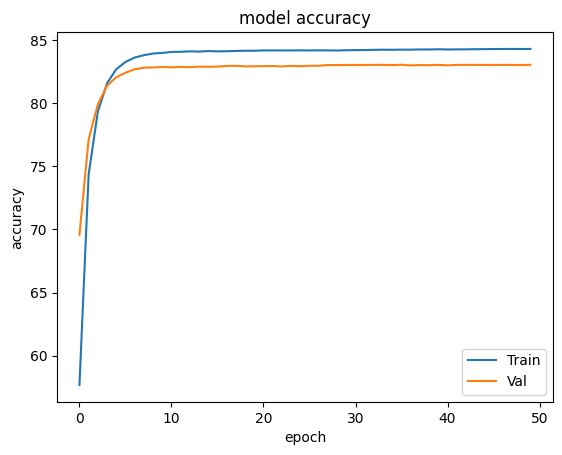

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist['train_accuracy'], label='Train')
plt.plot(hist['val_accuracy'], label='Val')


plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val' ], loc='lower right')
plt.show()

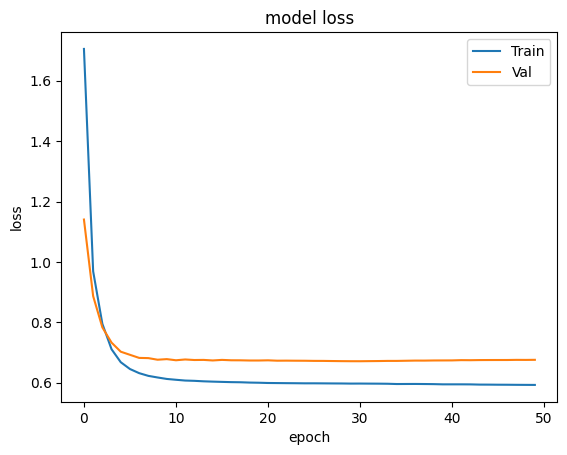

In [ ]:
plt.plot(hist['train_loss'], label='Train')
plt.plot(hist['val_loss'], label='Val')


plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val' ], loc='upper right')
plt.show()